In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import wrangle
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_string_data#, split_data

import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# ALL OF THE BELOW EXPLORATION NEEDS TO BE DONE ON TRAIN ONLY.  LET'S SPLIT UP HERE BASED ON A TSA APPROACH
### Other of our explorations might work slightly differently, if we do a prediction model or topic modeling

In [2]:
df = wrangle.get_npr_data()
df.head()

The df has 2998347 rows and 10 columns.


,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
episode_id,,,,,,,,,,
57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,False,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...,0.0000,2010-07-12
57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,False,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...,0.9313,2010-07-12
57264,11,"neal conan, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,2010-07-12
57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,False,that s right. each team has nine riders. and w...,right. team ha nine riders. basically team lea...,0.9274,2010-07-12
57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,2010-07-12


In [3]:
# This should be in wrangle now

# df['speaker'] = df.speaker.str.lower()
# df['is_host'] = df.speaker.str.contains(r'\W*(host)\W*')

In [4]:
df.sort_values(by=['episode_id','episode_order'])[0:50]

,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date
episode_id,,,,,,,,,,
1,1,"lulu garcia-navarro, host",The impeachment inquiry picks up tomorrow wher...,Weekend Edition Sunday,Sunday Politics,True,the impeachment inquiry picks up tomorrow wher...,impeachment inquiry pick tomorrow left friday ...,-0.5267,2019-10-06
1,2,"lulu garcia-navarro, host",Good morning.,Weekend Edition Sunday,Sunday Politics,True,good morning .,good morning .,0.4404,2019-10-06
1,3,"mara liasson, byline","Good morning, Lulu.",Weekend Edition Sunday,Sunday Politics,False,good morning lulu .,good morning lulu .,0.4404,2019-10-06
1,4,"lulu garcia-navarro, host",All right. What's the latest?,Weekend Edition Sunday,Sunday Politics,True,all right. what s the latest ?,right. latest ?,0.0000,2019-10-06
1,5,"mara liasson, byline","Well, the latest is that the lawyer for the fi...",Weekend Edition Sunday,Sunday Politics,False,well the latest is that the lawyer for the fir...,well latest lawyer first whistleblower tweetin...,0.8402,2019-10-06
1,6,"lulu garcia-navarro, host","I mean, another whistleblower has got to be ba...",Weekend Edition Sunday,Sunday Politics,True,i mean another whistleblower has got to be bad...,mean another whistleblower ha got bad news pre...,0.1027,2019-10-06
1,7,"mara liasson, byline",No. This is kind of like a trail of bread crum...,Weekend Edition Sunday,Sunday Politics,False,no. this is kind of like a trail of bread crum...,no. kind like trail bread crumbs. revelation l...,0.9153,2019-10-06
1,8,"lulu garcia-navarro, host",What his happening to his support among Republ...,Weekend Edition Sunday,Sunday Politics,True,what his happening to his support among republ...,happening support among republican lawmaker ma...,0.6662,2019-10-06
1,9,"mara liasson, byline","So far, most Republican lawmakers are shelteri...",Weekend Edition Sunday,Sunday Politics,False,so far most republican lawmakers are shelterin...,far republican lawmaker sheltering place usual...,-0.6705,2019-10-06


## Is there a difference in the mean sentiment by speaker? Program? etc
- Applied statistics-> i.e. stats testing. Is there a difference in the mean sentiment by speaker? Program? etc 

In [5]:
df.columns

Index(['episode_order', 'speaker', 'utterance', 'program', 'title', 'is_host',
       'clean', 'lemmatized_stopped', 'vader_stopped', 'date'],
      dtype='object')

In [6]:
df.shape

(2998347, 10)

In [7]:
df.dtypes

episode_order           int64
speaker                object
utterance              object
program                object
title                  object
is_host                  bool
clean                  object
lemmatized_stopped     object
vader_stopped         float64
date                   object
dtype: object

In [8]:
df.date = pd.to_datetime(df.date)

In [9]:
df.dtypes

episode_order                  int64
speaker                       object
utterance                     object
program                       object
title                         object
is_host                         bool
clean                         object
lemmatized_stopped            object
vader_stopped                float64
date                  datetime64[ns]
dtype: object

In [10]:

# df['Date'].dt.strftime('%b-%Y')

# df['episode_date'].dt.strftime('%b')

In [11]:
df['month']=df['date'].dt.strftime('%b')
df['year']=pd.DatetimeIndex(df['date']).year
df=df.reset_index()
df.head()

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,date,month,year
0,57264,9,"ms. loren mooney (editor-in-chief, bicycling m...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,False,it s a 2200 mile race. to give some sense of p...,2200 mile race. give sense perspective roughly...,0.0000,2010-07-12,Jul,2010
1,57264,10,"ms. loren mooney (editor-in-chief, bicycling m...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,False,so for a top competitor like lance to try to m...,top competitor like lance try make much time 1...,0.9313,2010-07-12,Jul,2010
2,57264,11,"neal conan, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,True,so in every team presumably there s one star o...,every team presumably one star one equivalent ...,0.7096,2010-07-12,Jul,2010
3,57264,12,"ms. loren mooney (editor-in-chief, bicycling m...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,False,that s right. each team has nine riders. and w...,right. team ha nine riders. basically team lea...,0.9274,2010-07-12,Jul,2010
4,57264,13,"neal conan, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,True,so slipstream this is like drafting in car rac...,slipstream like drafting car racing right ?,0.3612,2010-07-12,Jul,2010


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df=df.set_index('date').sort_index()

In [14]:
df = df[df.index.year >= 2005]

In [15]:
df.head(1)

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,month,year
date,,,,,,,,,,,,
2005-01-11,84431,112,"neal conan, host",Yeah. I suspect your habits have changed a li...,Talk of the Nation,California Rains Bring Rash of Mudslides,True,yeah. i suspect your habits have changed a lit...,yeah. suspect habit changed little bit .,0.0,Jan,2005


In [18]:
train = df[:'2015']
validate = df['2016':'2017']
test = df['2018':]
train.shape, validate.shape, test.shape

((2517208, 12), (248112, 12), (232647, 12))

In [20]:
train.index[-1:], validate.index[:1], validate.index[-1:], test.index[:1]

(DatetimeIndex(['2015-12-31'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2016-01-01'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2017-12-31'], dtype='datetime64[ns]', name='date', freq=None),
 DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', name='date', freq=None))

## Using train split from here

In [45]:
host_df = train[train.is_host==True]

In [46]:
host_df.shape

(898443, 12)

In [47]:
# are there repeats in the host_df? 
host_df.speaker.value_counts()

neal conan, host                                          255143
ira flatow, host                                           73188
robert siegel, host                                        43704
steve inskeep, host                                        41411
melissa block, host                                        38660
                                                           ...  
mary louis kelly, host                                         1
mr. don imus (radio host, "imus in the morning," wabc)         1
clip from news broadcast, host                                 1
mr. donald trump (host)                                        1
mr. bob saget (tv host; comedian)                              1
Name: speaker, Length: 835, dtype: int64

- I can see two different duplicates for steve inskeep bc of typos
- I think this is going to fall into the arena of significantly diminishing returns, and I will not address it at this time

In [48]:
hosts_with_the_most = host_df.speaker.value_counts().head(12).index.to_list()

- This is a list of the 12 hosts with the most observations

In [49]:
hosts_with_the_most

['neal conan, host',
 'ira flatow, host',
 'robert siegel, host',
 'steve inskeep, host',
 'melissa block, host',
 'farai chideya, host',
 'renee montagne, host',
 'guy raz, host',
 'madeleine brand, host',
 'scott simon, host',
 'michele norris, host',
 'alex chadwick, host']

In [50]:
top_hosts_df = train[train.speaker.isin(hosts_with_the_most)]

In [51]:
top_hosts_df.head(1)

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,month,year
date,,,,,,,,,,,,
2005-01-11,84431,112,"neal conan, host",Yeah. I suspect your habits have changed a li...,Talk of the Nation,California Rains Bring Rash of Mudslides,True,yeah. i suspect your habits have changed a lit...,yeah. suspect habit changed little bit .,0.0,Jan,2005


In [52]:
top_hosts_df.index.min(), top_hosts_df.index.max()

(Timestamp('2005-01-11 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [53]:
top_hosts_df.vader_stopped.mean()

0.16269110137462542

- Here, we have the average sentiment score for all the top hosts; as you can see, it is relatively neutral in sentiment

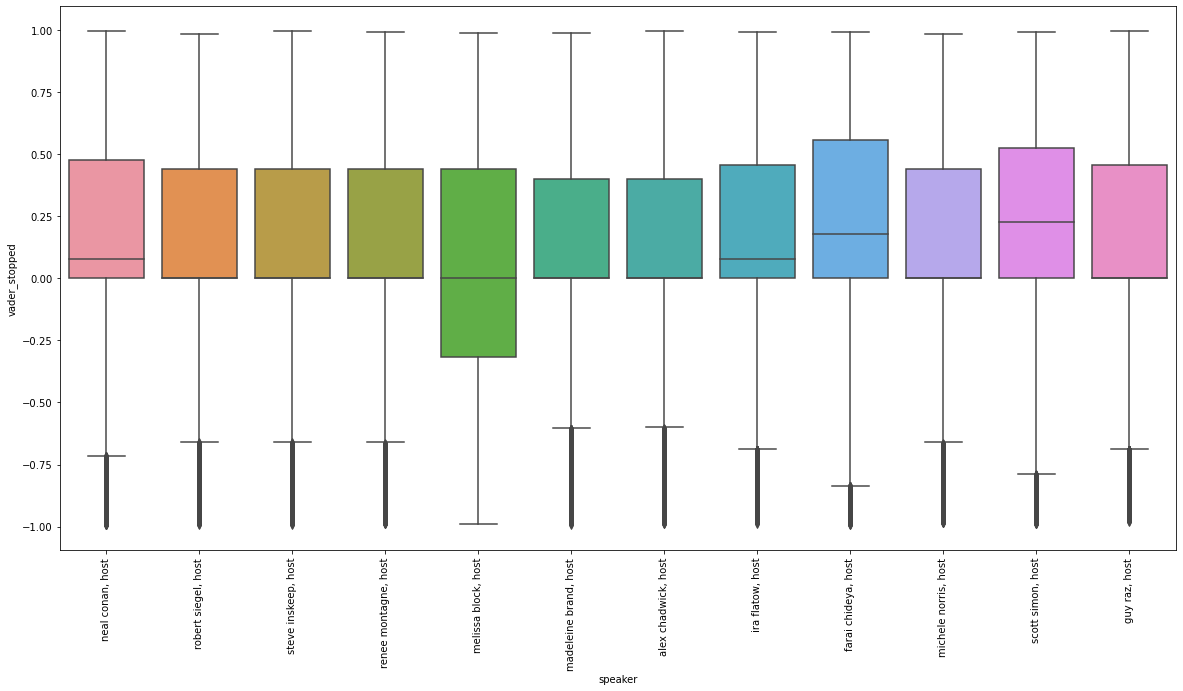

In [54]:
plt.figure(figsize=(20,10))
sns.boxplot(data=top_hosts_df, x='speaker',y='vader_stopped')
plt.xticks(rotation=90);

- The mean sentiment value is awfully close for everyone here, so i'm going to stats test it with an ANOVA test

In [55]:
null_hypothesis = "Average sentiment score is the same across hosts"
alternative_hypothesis = "Average sentiment score is different in at least one host of the group"
alpha = 0.01 # Let's be 99% certain the result we see isn't due to chance/randomness

In [56]:
host_df_list=[]
for host in hosts_with_the_most:
    x = host.split()
    host_df_list.append(f'{x[0]}_df')
print(host_df_list)

['neal_df', 'ira_df', 'robert_df', 'steve_df', 'melissa_df', 'farai_df', 'renee_df', 'guy_df', 'madeleine_df', 'scott_df', 'michele_df', 'alex_df']


In [57]:
hosts_with_the_most

['neal conan, host',
 'ira flatow, host',
 'robert siegel, host',
 'steve inskeep, host',
 'melissa block, host',
 'farai chideya, host',
 'renee montagne, host',
 'guy raz, host',
 'madeleine brand, host',
 'scott simon, host',
 'michele norris, host',
 'alex chadwick, host']

In [62]:
# Let's isolate our hosts
NEAL_df = train[train.speaker == 'neal conan, host'].vader_stopped
IRA_df = train[train.speaker ==  'ira flatow, host'].vader_stopped
ROBERT_df = train[train.speaker == 'robert siegel, host'].vader_stopped
STEVE_df = train[train.speaker == 'steve inskeep, host'].vader_stopped
MELISSA_df = train[train.speaker == 'melissa block, host'].vader_stopped
FARAI_df = train[train.speaker ==  'farai chideya, host'].vader_stopped
RENEE_df = train[train.speaker == 'renee montagne, host'].vader_stopped
GUY_df = train[train.speaker == 'GUY RAZ, host'].vader_stopped
MADELEINE_df = train[train.speaker == 'madeleine brand, host'].vader_stopped
SCOTT_df = train[train.speaker == 'scott simon, host'].vader_stopped
MICHELE_df = train[train.speaker == 'michelle norris, host'].vader_stopped
ALEX_df = train[train.speaker == 'alex chadwick, host'].vader_stopped


In [63]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(NEAL_df, IRA_df, STEVE_df, ROBERT_df, MELISSA_df, RENEE_df, FARAI_df, SCOTT_df, RACHEL_df, DAVID_df, MADELEINE_df)
f, p

(719.0343813728148, 0.0)

In [64]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that Average sentiment score is the same across hosts
We move forward with the alternative hypothesis that Average sentiment score is different in at least one host of the group


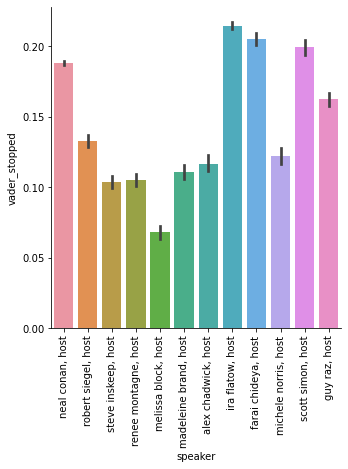

In [65]:
sns.catplot(x="speaker", y="vader_stopped", kind="bar", data=top_hosts_df)
plt.xticks(rotation=90);

- Another view of the same...it looks more clear here that there is a difference, however note the small scale on the y axis

In [66]:
top_hosts_df.head(1)

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,month,year
date,,,,,,,,,,,,
2005-01-11,84431,112,"neal conan, host",Yeah. I suspect your habits have changed a li...,Talk of the Nation,California Rains Bring Rash of Mudslides,True,yeah. i suspect your habits have changed a lit...,yeah. suspect habit changed little bit .,0.0,Jan,2005


### The conclusion to the above is that there is a statistically significant difference in sentiment in the top hosts group, even if it is small.

## What's the difference in sentiment score between hosts and non-hosts?

In [67]:
non_host_df = train[train.is_host==False]

Text(0, 0.5, 'Mean Sentiment Score')

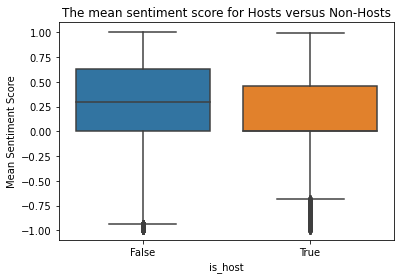

In [68]:
plt.figure
sns.boxplot(data=train, x='is_host',y='vader_stopped')
plt.title("The mean sentiment score for Hosts versus Non-Hosts")
plt.ylabel("Mean Sentiment Score")


In [69]:
train[train.is_host==False].vader_stopped.mean(), train[train.is_host==True].vader_stopped.mean()

(0.2223866217147498, 0.1697898983018411)

In [70]:
null_hypothesis = "Hosts and Non-hosts have the same sentiment score"
alternative_hypothesis = "Hosts and Non-hosts have different sentiment scores"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [71]:
#stats testing on the same
# anova is the wrong test!
from scipy import stats

t, p = stats.ttest_ind(host_df.vader_stopped,non_host_df.vader_stopped)
t, p

(-85.95950067866178, 0.0)

In [72]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print(f"Evidence does not support the claim that", alternate_hypothesis)

We reject the null hypothesis that Hosts and Non-hosts have the same sentiment score
We move forward with the hypothesis that Hosts and Non-hosts have different sentiment scores


### The average sentiment score for non-hosts is somewhat higher than for the hosts.  To be expected for a relatively neutral news outlet?

## How about sentiment score by year?

In [73]:
train.resample('Y').vader_stopped.mean()

date
2005-12-31    0.195450
2006-12-31    0.186313
2007-12-31    0.199343
2008-12-31    0.231347
2009-12-31    0.222994
2010-12-31    0.212010
2011-12-31    0.201472
2012-12-31    0.220675
2013-12-31    0.191282
2014-12-31    0.161404
2015-12-31    0.168365
Freq: A-DEC, Name: vader_stopped, dtype: float64

- why don't we have vader scores in 2000-2003 on yearly resampling?

In [74]:
vader_yearly = pd.DataFrame(train.resample('Y').vader_stopped.mean())

<AxesSubplot:xlabel='date'>

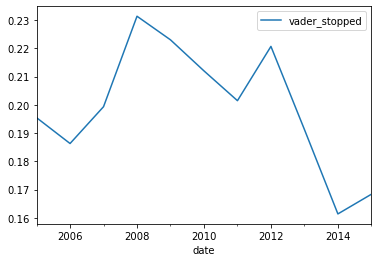

In [75]:
vader_yearly.plot()

In [76]:
vader_monthly = pd.DataFrame(train.resample('M').vader_stopped.mean())

In [77]:
vader_monthly.head()

,vader_stopped
date,
2005-01-31,0.310612
2005-02-28,NaN
2005-03-31,NaN
2005-04-30,NaN
2005-05-31,0.198613


<AxesSubplot:xlabel='date'>

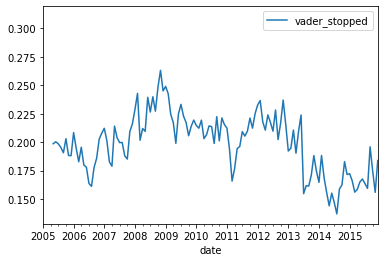

In [78]:
vader_monthly.plot()

- What's with all those missing sentiment scores in the early aughts?

In [81]:
# pd.DataFrame(df.resample("d").vader_stopped.mean()).plot()

## By day of week?

In [82]:
train.groupby(train.index.weekday).vader_stopped.mean()
# sentiment by day, 0 is monday, 6 is sunday

date
0    0.198355
1    0.195280
2    0.202373
3    0.203400
4    0.221336
5    0.198300
6    0.201500
Name: vader_stopped, dtype: float64

<AxesSubplot:xlabel='date', ylabel='vader_stopped'>

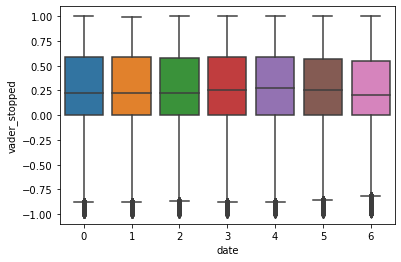

In [84]:
sns.boxplot(data=train, x=train.index.weekday,y='vader_stopped')

In [85]:
Monday_df = train[train.index.weekday == 0]
Tuesday_df = train[train.index.weekday == 1]
Wednesday_df = train[train.index.weekday == 2]
Thursday_df = train[train.index.weekday == 3]
Friday_df = train[train.index.weekday == 4]
Saturday_df = train[train.index.weekday == 5]
Sunday_df = train[train.index.weekday == 6]

In [86]:
null_hypothesis = "Different days of the week have the same sentiment score"
alternative_hypothesis = "At least one day of the week has a different sentiment score from the rest"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [87]:
from scipy.stats import f_oneway

f, p = f_oneway(Monday_df.vader_stopped,\
Tuesday_df.vader_stopped,\
Wednesday_df.vader_stopped,\
Thursday_df.vader_stopped,\
Friday_df.vader_stopped,\
Saturday_df.vader_stopped,\
Sunday_df.vader_stopped)

f, p

(140.89827783149474, 2.567874153812689e-179)

In [88]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from one weekday to the next")

We reject the null hypothesis that Different days of the week have the same sentiment score
We move forward with the alternative hypothesis that At least one day of the week has a different sentiment score from the rest


## And by program?

In [89]:
train.program.value_counts().index.to_list()

['Talk of the Nation',
 'All Things Considered',
 'Morning Edition',
 'News & Notes',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday']

In [90]:
Talk_of_the_Nation_df = train[train.program == 'Talk of the Nation']
All_Things_Considered_df = train[train.program == 'All Things Considered']
Morning_Edition_df = train[train.program == 'Morning Edition']
News_and_Notes_df = train[train.program == 'News & Notes']
Day_to_Day_df = train[train.program == 'Day to Day']
Weekend_Edition_Sunday_df = train[train.program == 'Weekend Edition Sunday']
Weekend_Edition_Saturday_df = train[train.program == 'Weekend Edition Saturday']

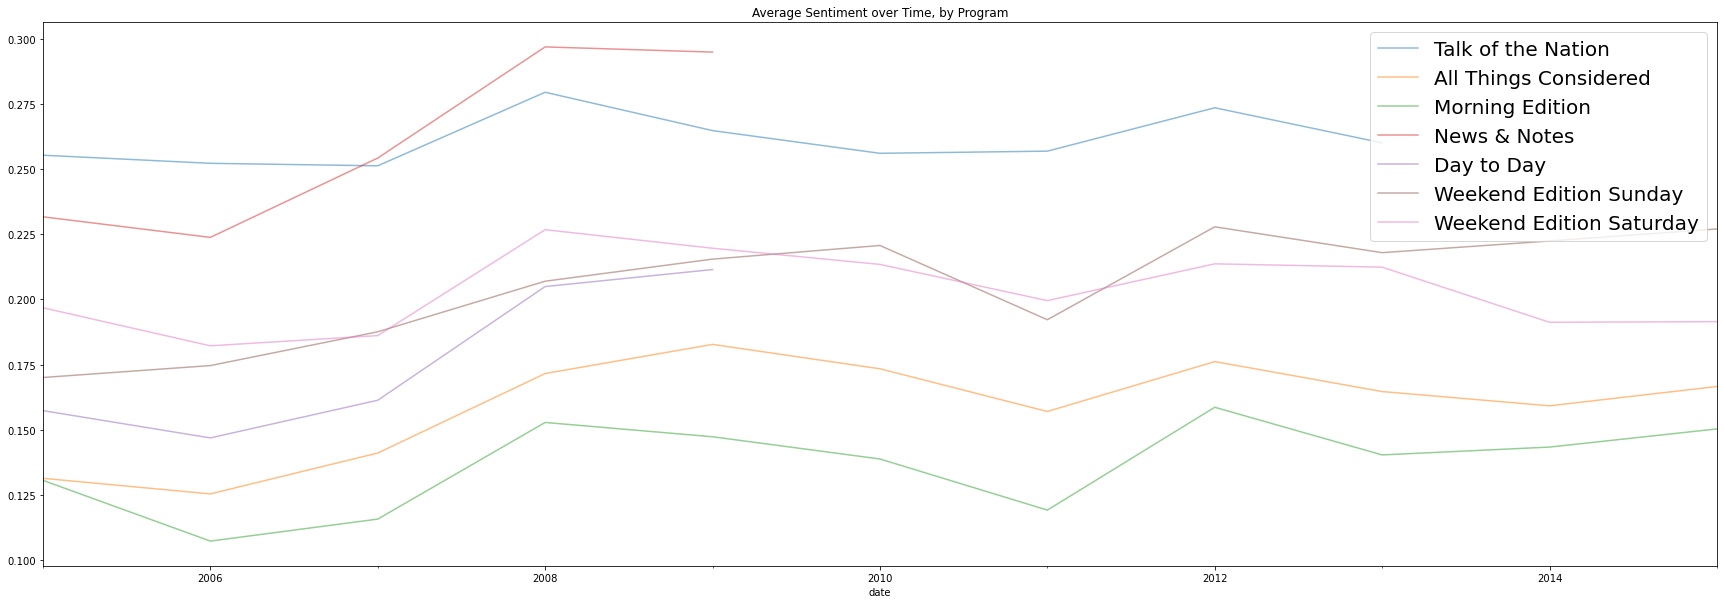

In [93]:
plt.figure(figsize=(30,10))
Talk_of_the_Nation_df.resample("y").vader_stopped.mean().plot(alpha=.5)
All_Things_Considered_df.resample("y").vader_stopped.mean().plot(alpha=.5)
Morning_Edition_df.resample("y").vader_stopped.mean().plot(alpha=.5)
News_and_Notes_df.resample("y").vader_stopped.mean().plot(alpha=.5)
Day_to_Day_df.resample("y").vader_stopped.mean().plot(alpha=.5)
Weekend_Edition_Sunday_df.resample("y").vader_stopped.mean().plot(alpha=.5)
Weekend_Edition_Saturday_df.resample("y").vader_stopped.mean().plot(alpha=.5)
plt.title("Average Sentiment over Time, by Program")
plt.legend(['Talk of the Nation',
 'All Things Considered',
 'Morning Edition',
 'News & Notes',
 'Day to Day',
 'Weekend Edition Sunday',
 'Weekend Edition Saturday'], prop={'size': 20})

- Note the programs that have gone off air
- Also, there is some difference in sentiment from program to program
- Weekend Edition (Sat and Sun) have higher sentiment scores--these programs try to be a little on the lighter side for the weekend
- We're definitely starting off the day on the most pessimistic note

In [94]:
null_hypothesis = "The different programs have the same sentiment score"
alternative_hypothesis = "At least one program has a different sentiment score"
alpha = 0.01 # we want to be 99% sure our results aren't the result of chance/randomness

In [95]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

f, p = f_oneway(Talk_of_the_Nation_df.vader_stopped,
All_Things_Considered_df.vader_stopped,
Morning_Edition_df.vader_stopped,
News_and_Notes_df.vader_stopped,
Day_to_Day_df.vader_stopped,
Weekend_Edition_Sunday_df.vader_stopped,
Weekend_Edition_Saturday_df.vader_stopped,)
f, p

(5207.896998736971, 0.0)

In [96]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that sentiment differs from host to host")

We reject the null hypothesis that The different programs have the same sentiment score
We move forward with the alternative hypothesis that At least one program has a different sentiment score


In [97]:
df.head()

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,month,year
date,,,,,,,,,,,,
2005-01-11,84431,112,"neal conan, host",Yeah. I suspect your habits have changed a li...,Talk of the Nation,California Rains Bring Rash of Mudslides,True,yeah. i suspect your habits have changed a lit...,yeah. suspect habit changed little bit .,0.0000,Jan,2005
2005-01-11,84431,117,jim (caller),"Yes, we will.",Talk of the Nation,California Rains Bring Rash of Mudslides,False,yes we will .,yes .,0.4019,Jan,2005
2005-01-11,84431,116,"neal conan, host","Jim, good luck and keep shoveling.",Talk of the Nation,California Rains Bring Rash of Mudslides,True,jim good luck and keep shoveling .,jim good luck keep shoveling .,0.7096,Jan,2005
2005-01-11,84431,107,rob (caller),"Yes, sir. Good to talk to you. Just wanted t...",Talk of the Nation,California Rains Bring Rash of Mudslides,False,yes sir. good to talk to you. just wanted to t...,yes sir. good talk you. wanted throw quick com...,0.9460,Jan,2005
2005-01-11,84431,108,"neal conan, host","OK. Rob, thanks for the tips, and we apprecia...",Talk of the Nation,California Rains Bring Rash of Mudslides,True,ok. rob thanks for the tips and we appreciate ...,ok. rob thanks tip appreciate .,0.4939,Jan,2005


## what about clustering?
- There is very little continuous data here, clusering might not be possible.
- datetime...but how usefull can that be? 
- utterance order? is that available?

In [101]:
train.sort_values(by=['episode_id','episode_order'])[0:50]

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,month,year
date,,,,,,,,,,,,
2013-06-27,619,1,"neal conan, host","This is TALK OF THE NATION. I'm Neal Conan, in...",Talk of the Nation,What's The Talk Of Your Nation?,True,this is talk of the nation. i m neal conan in ...,talk nation. neal conan washington. every day ...,0.5719,Jun,2013
2013-06-27,619,2,"neal conan, host","On our last day, we think it's appropriate for...",Talk of the Nation,What's The Talk Of Your Nation?,True,on our last day we think it s appropriate for ...,last day think appropriate set agenda. call te...,0.9034,Jun,2013
2013-06-27,619,3,"neal conan, host",And if you want to tell us what's the talk of ...,Talk of the Nation,What's The Talk Of Your Nation?,True,and if you want to tell us what s the talk of ...,want tell u talk nation phone number 800 989 8...,0.4215,Jun,2013
2013-06-27,619,4,"neal conan, host",And let's see if we can get Heather on the lin...,Talk of the Nation,What's The Talk Of Your Nation?,True,and let s see if we can get heather on the lin...,let see get heather line. heather u tampa .,0.0000,Jun,2013
2013-06-27,619,5,heather,"Hi, yes. I think one of the most important thi...",Talk of the Nation,What's The Talk Of Your Nation?,False,hi yes. i think one of the most important thin...,hi yes. think one important thing going right ...,0.6249,Jun,2013
2013-06-27,619,6,"neal conan, host",And the filibuster the other day by State Sena...,Talk of the Nation,What's The Talk Of Your Nation?,True,and the filibuster the other day by state sena...,filibuster day state senator wendy davis .,0.0000,Jun,2013
2013-06-27,619,7,heather,"Right, which is absolutely incredible. She des...",Talk of the Nation,What's The Talk Of Your Nation?,False,right which is absolutely incredible. she dese...,right absolutely incredible. deserves incredib...,0.7713,Jun,2013
2013-06-27,619,8,"neal conan, host",And you know that the governor plans to call a...,Talk of the Nation,What's The Talk Of Your Nation?,True,and you know that the governor plans to call a...,know governor plan call another session think ...,0.7778,Jun,2013
2013-06-27,619,9,heather,"I do know that, and I'm incredibly disappointe...",Talk of the Nation,What's The Talk Of Your Nation?,False,i do know that and i m incredibly disappointed...,know incredibly disappointed governor perry de...,-0.5256,Jun,2013


### Ok, for the first time I'm seeing clearly how the episodes are in fact ordered by 'story' (episode_id) and then ordered by utterance within the story

### This is great, bc it's what is going to make topic modeling possible down the line

# First...
- Let's do a tsa model of sentiment using Prophet : )

In [102]:
train.columns

Index(['episode_id', 'episode_order', 'speaker', 'utterance', 'program',
       'title', 'is_host', 'clean', 'lemmatized_stopped', 'vader_stopped',
       'month', 'year'],
      dtype='object')

In [115]:
for_tsa_modeling_df = pd.DataFrame(df['vader_stopped'])

In [116]:
for_tsa_modeling_df.head()

,vader_stopped
date,
2005-01-11,0.0000
2005-01-11,0.4019
2005-01-11,0.7096
2005-01-11,0.9460
2005-01-11,0.4939


In [117]:
# for_prophet_df.resample('Y').mean()
for_tsa_modeling_df.index.year.value_counts()

2007    338513
2006    311943
2008    308217
2009    260834
2010    252092
2011    229859
2012    229095
2005    188440
2013    177268
2018    129040
2017    127144
2016    120968
2014    112212
2015    108735
2019    103607
Name: date, dtype: int64

- there is NOTHING in there fro 2000 to 2003
- 2004 barely a thing

In [118]:

tsa_train = for_tsa_modeling_df['2005':'2015']
tsa_validate = for_tsa_modeling_df['2016':'2017']
tsa_test = for_tsa_modeling_df['2018':]
tsa_train.shape, tsa_validate.shape, tsa_test.shape

((2517208, 1), (248112, 1), (232647, 1))

- I've dropped all observations prior to 2005 in this split due to the problem with the data

In [119]:
tsa_train[-1:], tsa_validate[:1], tsa_validate[-1:], tsa_test[:1]

(            vader_stopped
 date                     
 2015-12-31         0.6705,
             vader_stopped
 date                     
 2016-01-01         0.3612,
             vader_stopped
 date                     
 2017-12-31         0.2023,
             vader_stopped
 date                     
 2018-01-01         0.2732)

- the splits look good

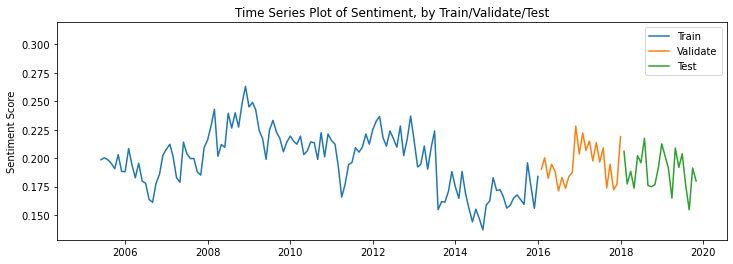

In [120]:
# for col in prophet_train.columns:
plt.figure(figsize=(12,4))
plt.plot(tsa_train.resample('M').vader_stopped.mean())
plt.plot(tsa_validate.resample('M').vader_stopped.mean())
plt.plot(tsa_test.resample('M').vader_stopped.mean())
plt.ylabel('Sentiment Score')
plt.title('Time Series Plot of Sentiment, by Train/Validate/Test')
plt.legend(labels = ["Train","Validate","Test"])
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

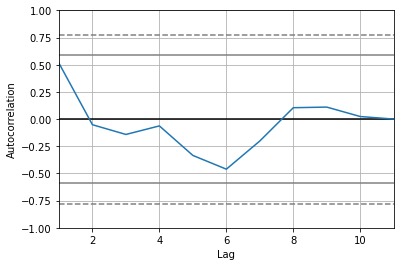

In [125]:
pd.plotting.autocorrelation_plot(tsa_train.resample('y').mean())

- There doesn't look to be any seasonality to speak of--try running the autocorrelation_plot with different resmample lengths
- from the curriculum:
    - "The dashed lines are a way measure whether the observed autocorrelation is a meaningful signal or just white noise. If the majority of the peaks and valleys fall within the dashed lines, the time series is probably white noise."

In [126]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

<AxesSubplot:xlabel='date'>

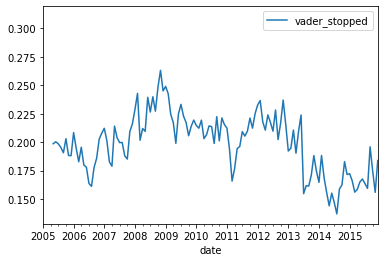

In [127]:
# prophet_train.dropna(axis=0, how='any')
tsa_train.dropna(axis=0, how='any').resample('M').mean().plot()

In [131]:
tsa_train[tsa_train.vader_stopped.isnull() == True]

,vader_stopped
date,


In [136]:
# tsa_train['vader_stopped'] = tsa_train['vader_stopped'].fillna(0)

In [139]:
# sm.tsa.seasonal_decompose(tsa_train.resample('M').mean()).plot()


# _ = sm.tsa.seasonal_decompose(tsa_train['vader_stopped'].resample('W').mean()).plot()


# ValueError: This function does not handle missing values


### Simple Average Model

In [140]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [141]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [142]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [144]:
score = round(tsa_train['vader_stopped'].mean(), 4)

def make_predictions():
    yhat_df = pd.DataFrame({'vader_stopped': score}, index = validate.index)

    return yhat_df

yhat_df = make_predictions()

In [145]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [146]:
# plot and evaluate 
def plot_and_eval_2(target_var,model_type):
    plt.figure(figsize = (12,4))
    plt.plot(tsa_train[target_var].resample('M').mean(), label = 'Train', linewidth = 1)
    plt.plot(tsa_validate[target_var].resample('M').mean(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(f"{target_var}, {model_type}")
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

In [147]:
yhat_df.head()

,vader_stopped
date,
2016-01-01,0.2036
2016-01-01,0.2036
2016-01-01,0.2036
2016-01-01,0.2036
2016-01-01,0.2036


vader_stopped -- RMSE: 0.4729


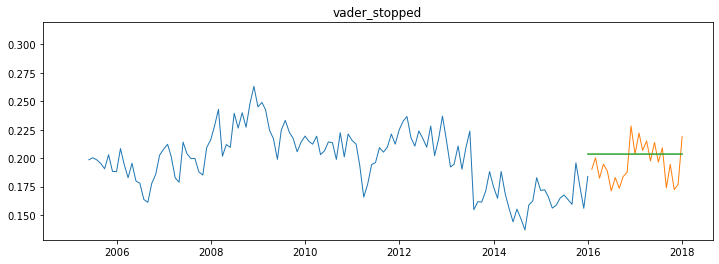

In [148]:
plot_and_eval('vader_stopped')

In [149]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'vader_stopped')

In [150]:
eval_df

,model_type,target_var,rmse
0,simple_average,vader_stopped,0.4729


### Moving Average

In [151]:
train['vader_stopped'].rolling(3).mean()

date
2005-01-11         NaN
2005-01-11         NaN
2005-01-11    0.370500
2005-01-11    0.685833
2005-01-11    0.716500
                ...   
2015-12-31   -0.090567
2015-12-31    0.400100
2015-12-31    0.085200
2015-12-31   -0.157800
2015-12-31   -0.191533
Name: vader_stopped, Length: 2517208, dtype: float64

vader_stopped -- RMSE: 0.5025


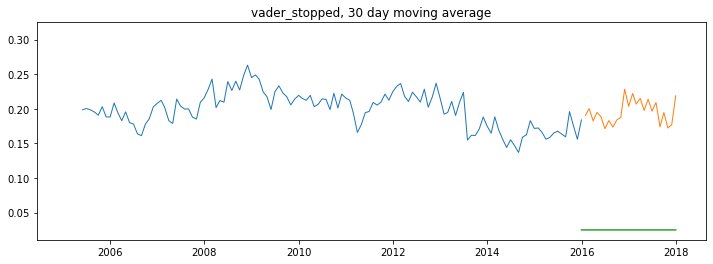

vader_stopped -- RMSE: 0.4816


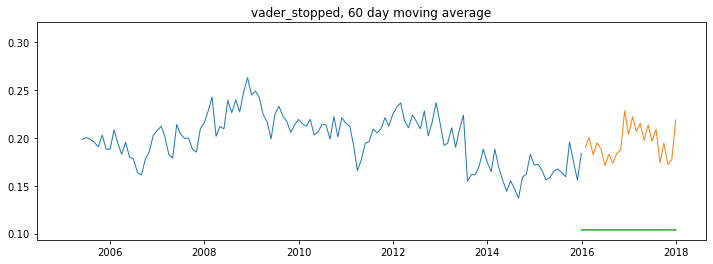

vader_stopped -- RMSE: 0.4801


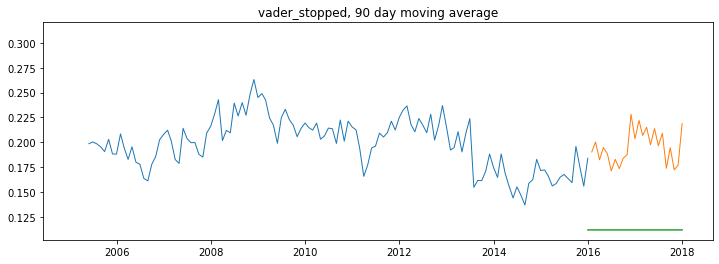

vader_stopped -- RMSE: 0.4741


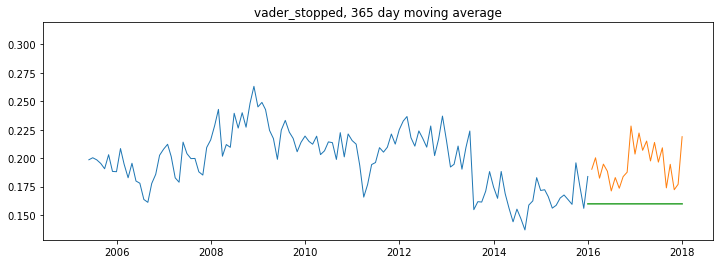

,model_type,target_var,rmse
0,simple_average,vader_stopped,0.4729
1,30 day moving average,vader_stopped,0.5025
2,60 day moving average,vader_stopped,0.4816
3,90 day moving average,vader_stopped,0.4801
4,365 day moving average,vader_stopped,0.4741


In [152]:
# Trying with different periods

periods = [30, 60, 90, 365]

for p in periods:
    score = round(tsa_train['vader_stopped'].rolling(p).mean().iloc[-1], 4)
    yhat_df = make_predictions()
    model_type = str(p) + ' day moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'vader_stopped'
                            )
    plot_and_eval_2('vader_stopped', model_type)
eval_df

In [153]:
yhat_df

,vader_stopped
date,
2016-01-01,0.1599
2016-01-01,0.1599
2016-01-01,0.1599
2016-01-01,0.1599
2016-01-01,0.1599
...,...
2017-12-31,0.1599
2017-12-31,0.1599
2017-12-31,0.1599


# In case you missed it: there's something wrong with the moving average models, which shouldn't be so low.  Or am I wrong?


In [154]:
# _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
# plt.show()

# Still having problems loooking at seasonl decomposition due to missing valuese

In [156]:
tsa_validate.index[-1]

Timestamp('2017-12-31 00:00:00')

In [157]:
tsa_train['vader_stopped'].resample('M').mean()

date
2005-01-31    0.310612
2005-02-28         NaN
2005-03-31         NaN
2005-04-30         NaN
2005-05-31    0.198613
                ...   
2015-08-31    0.159453
2015-09-30    0.195930
2015-10-31    0.175029
2015-11-30    0.155952
2015-12-31    0.183937
Freq: M, Name: vader_stopped, Length: 132, dtype: float64

In [159]:
# model = Holt(tsa_train['vader_stopped'], exponential = False)
# model = model.fit(smoothing_level = .1, 
#                   smoothing_slope = .1, 
#                   optimized = False)
# yhat_items = model.predict(start = validate.index[0], 
#                            end = validate.index[-1])
# yhat_df['vader_stopped'] = round(yhat_items, 4)

#HOLTS IS BROKEN : (

# KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'


In [ ]:
yhat_df.head()
# the above is returning NaNs only

In [ ]:
# plot_and_eval('vader_stopped')

### Moving prophet model to its own notebook bc of the size of it (not pushing to github)

## The confidence intervals on the Prophet model were massive.  The sentiment observations in this data are very close together and yield rather little predictive power

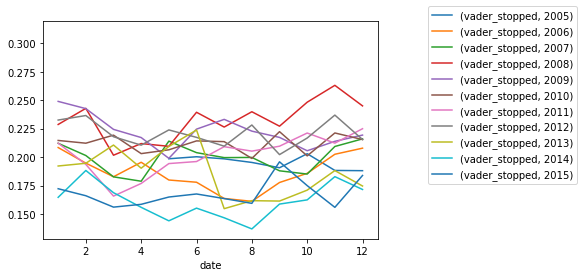

In [165]:
tsa_train.groupby([tsa_train.index.year, tsa_train.index.month]).mean().unstack(0).plot()
plt.legend(loc=(1.3,.5), bbox_to_anchor=(0.5, 0., 0.5, 0.5))

- Is there a trend of dipping sentiment in the summer?

In [166]:
df.head()

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized_stopped,vader_stopped,month,year
date,,,,,,,,,,,,
2005-01-11,84431,112,"neal conan, host",Yeah. I suspect your habits have changed a li...,Talk of the Nation,California Rains Bring Rash of Mudslides,True,yeah. i suspect your habits have changed a lit...,yeah. suspect habit changed little bit .,0.0000,Jan,2005
2005-01-11,84431,117,jim (caller),"Yes, we will.",Talk of the Nation,California Rains Bring Rash of Mudslides,False,yes we will .,yes .,0.4019,Jan,2005
2005-01-11,84431,116,"neal conan, host","Jim, good luck and keep shoveling.",Talk of the Nation,California Rains Bring Rash of Mudslides,True,jim good luck and keep shoveling .,jim good luck keep shoveling .,0.7096,Jan,2005
2005-01-11,84431,107,rob (caller),"Yes, sir. Good to talk to you. Just wanted t...",Talk of the Nation,California Rains Bring Rash of Mudslides,False,yes sir. good to talk to you. just wanted to t...,yes sir. good talk you. wanted throw quick com...,0.9460,Jan,2005
2005-01-11,84431,108,"neal conan, host","OK. Rob, thanks for the tips, and we apprecia...",Talk of the Nation,California Rains Bring Rash of Mudslides,True,ok. rob thanks for the tips and we appreciate ...,ok. rob thanks tip appreciate .,0.4939,Jan,2005
